# Multiple ACVs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import mdtraj as md
import fretraj as ft
import seaborn as sns

Let's load in an .xtc trajectory from a Gromacs MD run where snapshots are saved every 10 ns (note: time units of MDtraj are picoseconds)

In [2]:
traj = md.load_xtc('DNA_every10ns.xtc', top='DNA.pdb')

In [3]:
print(f'timestep: {traj.timestep/1000:0.0f} ns')
print(f'length: {traj.time[-1]/1000:0.0f} ns')

timestep: 10 ns
length: 200 ns


Select only the nucleic acid residues and remove the ions 

In [4]:
nucleic = traj.top.select('resn A or resn G or resn C or resn U')

In [5]:
table, bonds = traj.top.to_dataframe()

Next, let's define the attachement points and the dye-linker dimensions. We choose the `O5'` at the 5'-end of either chain as the attachment sites.

In [6]:
labels = {"Position":
            {"Cy3":
                {"attach_id": 622,
                 "linker_length": 21,
                 "linker_width": 5,
                 "dye_radius1": 8.0,
                 "dye_radius2": 3.0,
                 "dye_radius3": 1.5},
            "Cy5":
                {"attach_id": 1371,
                 "linker_length": 20.5,
                 "linker_width": 5,
                 "dye_radius1": 9.5,
                 "dye_radius2": 3.0,
                 "dye_radius3": 1.5}},
          "Distance": {"Cy3-Cy5":
            {"R0": 54}}}

In [8]:
labels = ft.cloud.check_labels(labels, verbose=False)

Calculate ACVs for all snapshots along the trajectory

In [201]:
don = ft.cloud.Volume.from_frames(traj, 'Cy3', labels, range(20))
acc = ft.cloud.Volume.from_frames(traj, 'Cy5', labels, range(20))

Empty Accessible volume at position 622. Is your attachment point buried?
Empty Accessible volume at position 622. Is your attachment point buried?
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete


Similary, compute the FRET efficiency over the trajectory

In [202]:
fret = []
for i in range(20):
    fret.append(ft.cloud.FRET_Trajectory(don[i], acc[i], 'Cy3-Cy5', labels))

One accessible volume is empty
One accessible volume is empty


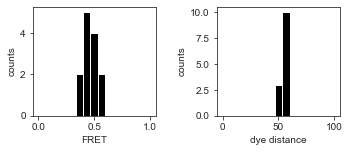

In [235]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,2,figsize=(5.5,2), squeeze=False, gridspec_kw={'wspace':0.5})
    ax[0,0].hist([fret[i].mean_E_DA for i in range(15) if hasattr(fret[i], 'mean_E_DA')], range=(0,1), bins=15, color='k')
    ax[0,0].set_xlabel('FRET')
    ax[0,0].set_ylabel('counts')
    
    ax[0,1].hist([fret[i].mean_R_DA for i in range(15) if hasattr(fret[i], 'mean_R_DA')], range=(0,100), bins=15, color='k')
    ax[0,1].set_xlabel('dye distance')
    ax[0,1].set_ylabel('counts')